# Analyzing Ulysses with NLTK: Lestrygonians (Ch. 8)

## Part III: Tagging and Frequency Analysis

<br />
<br />
<br />

### Table of Contents
* [Introduction](#intro)
* Tagging Words:
 * [Creating Word Tag DataFrame](#wordtagdf)
* Word Frequencies and Fourier Transforms:
 * [Plotting Intermittencies of Words](#intermittencies)
 * [Analyzing Word Frequencies with FFT](#fft)
 * [Word Freqency and Corresponding Signal](#wordfreq)
* Word Frequencies and Wavelets:
 * [Using Wavelets to Examine the Time-Frequency Domain](#wavelets)
 * [Chunking Chapters with Wavelets](#chunking)

<br />
<br />
<br />


## Introduction

(Here, I'll explain the approach we are using to tag individual words. Currently a regex-based approach that creates a DataFrame with one row per word. Next steps will be looking for multiple regex matches, and creating broader topical categories, like "death" or "body parts," potentially associated with lots of different words.)

(Also need to explain sentence tagging - not implemented yet, but this will utilize a similar approach, creating a dataframe with one sentence per row, and tagging each sentence with words, topics, etc.)

In [1]:
# In case we want to plot something:
%matplotlib inline 

# I'm from the future and I'm here to help
from __future__ import division

# The io module makes unicode easier to deal with
import io

def p():
    print "-"*20

In [2]:
file_contents = io.open('txt/08lestrygonians.txt','r').read()

In [3]:
import nltk, re
import numpy as np
import pandas as pd

# We're about to get plotted up in this business
import seaborn as sns
from matplotlib.pylab import *

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


<a name="wordtagdf"></a>
## Creating Word Tag DataFrame

In [168]:
words = nltk.word_tokenize(file_contents)
print len(words)

wdf = pd.DataFrame(columns=['WORD'],data=words)

def regex_to_column(label,regex,wdf):
    wdf[label] = wdf.apply( lambda x : len( re.findall(regex,x.values[0])), axis=1)

15153


Now we'll apply the `regex_to_column()` method to tag occurrences of particular regular expressions:

In [171]:
regex_to_column('pt verb', r'ed$', wdf)
regex_to_column('eye', r'^eye', wdf)
regex_to_column('Bloom', r'Bloom', wdf)
regex_to_column('God', r'God', wdf)
regex_to_column('knife', r'kni[fv]e', wdf)
regex_to_column('oo', r'oo', wdf)
regex_to_column('and', r'^and$', wdf)
regex_to_column('is', r'^is$', wdf)
regex_to_column('blue', r'blue$', wdf)
regex_to_column('green', r'green$', wdf)
regex_to_column('yellow', r'^yellow', wdf)

regex_to_column('guts', r'^guts', wdf)
regex_to_column('Molly', r'Molly', wdf)
regex_to_column('he', r'he', wdf)
regex_to_column('she', r'she', wdf)
regex_to_column('him', r'^hi[ms]$', wdf)
regex_to_column('her', r'^her[s]{0,}$', wdf)
regex_to_column('was',r'^was', wdf)
regex_to_column('could',r'^could', wdf)


wdf['length'] = wdf.apply( lambda x : 1.0/len( x.values[0] ), axis=1)

In [172]:
colors = sns.xkcd_palette(["windows blue", "amber", "faded green", "dusty purple","aqua blue"])

<a name="intermittencies"></a>
## Plotting Intermittencies Between Words

Now that we have created vectors of 0s and 1s representing whether words in the chapter are a particular word, we can count up the number of 0s that occur, and examine the distribution. This will give us a sense of how often a particular word appears, and whether (and to what extent) those appearances are clustered together.



In [173]:
def plot_intermittency(key,words_df):
    counts =[]
    counter = 0
    for (ii,yy) in enumerate(words_df[key]):
        if yy>0:
            counts.append(counter)
            counter = 0
        else:
            counter += 1
        
    nn = len(words_df[key])
    invcounts = [1/c for c in counts if(c > 0)]
    hist(invcounts,bins=20)
    
    xlabel('Word Frequency: occurrences per unit novel')
    ylabel('Count')
    title(key)
    show()

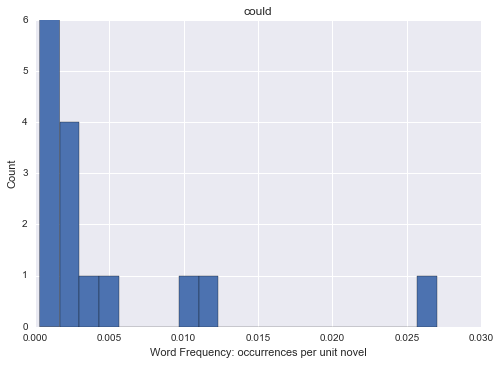

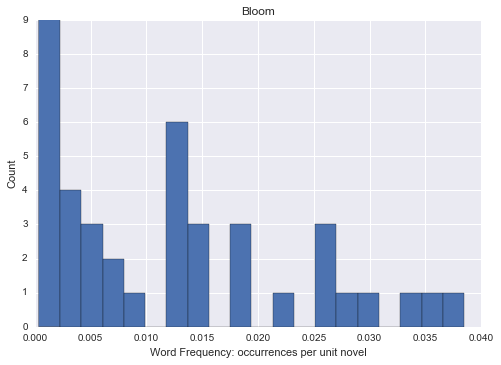

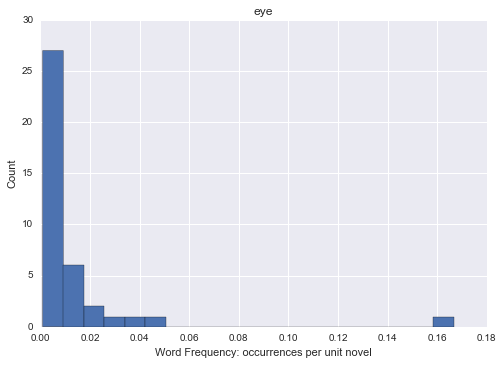

In [174]:
plot_intermittency('could',wdf)
plot_intermittency('Bloom',wdf)
plot_intermittency('eye',wdf)

<a name="fft"></a>
## Analyzing Word Frequencies with FFT

 we can take the Fourier transform of these variables to see the most common frequencies for occurrences of that word.

The Fourier transform will determine the coefficients of a large number of sine waves of various frequencies (in this case, the number of frequencies is equal to half the number of samples). These coefficients, called Fourier coefficients, can be plotted, and any frequencies that occur more commonly for a particular word will manifest as a large peak in the plot of Fourier coefficients.


In [175]:
def fft_column(key,words_df):
    n = len(words_df) # length of signal
    
    k = np.arange(n) 
    t = words_df.index.values
    y = words_df[key].values

    frq = k/n # two-sided frequency range
    frq = frq[1:int(n/2)] # one-sided frequency range
    
    Y = np.fft.fft(y) # fft computing and normalization
    Y = Y[1:int(n/2)]

    return (frq, Y)

In [176]:
def fft_plots(key,words_df):
    
    (frq,Y) = fft_column(key,words_df)

    t = words_df.index.values
    y = words_df[key]
    
    # Make a rug plot:
    # 0 where it is not the key word
    # 1 where it is the key word
    fig = figure(figsize=(14,0.5))
    
    ax1 = fig.add_subplot(111)
    
    ax1.plot(t,y,color=colors[0])
    ax1.set_xlabel('Word Location')
    ax1.set_ylabel('Amplitude')
    ax1.set_ylim([0,1])
    ax1.set_title('Rug Plot: '+str(key))
    
    # Make a freq domain plot:
    # FFT magnitude vs Frequency 
    fig = figure(figsize=(14,4))
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    ax1.plot(frq, Y, color=colors[1]) # plotting the spectrum
    ax1.set_xlabel('Freq (per word)')
    ax1.set_ylabel('|Y(freq)|')
    ax1.set_title('FFT: '+str(key))
    
    ax2.loglog(frq, Y**2, 'o', color=colors[2]) # plotting the spectrum
    #ax2.semilogx(frq[26:], log(abs(Y[26:])), 'o', color=colors[3]) # plotting the spectrum
    ax2.set_xlabel('Freq (per word)')
    ax2.set_ylabel('|Y(freq)|')
    ax2.set_title('Log FFT: '+str(key))   
    show()
    
    return (t,Y)
    

Now let's look at this plot for one of the most common words in the English language: "is". The first "rug" plot visualizes the occurrence vector (the vector of 0s and 1s that indicate if a word is the word "is").

The two plots below that are plots of the Fourier coefficients. The plot on the left shows the magnitude of the Fourier coefficients versus frequency, while the plot on the right shows the same quantity on a log-log plot.

<a name="wordfreq"></a>
## Word Frequency and Corresponding Signal

The 0s and 1s in each word vector aren't quite frequencies, but they can be converted into frequencies. By adding up the spaces in between each occurence of a given word, we can bin them up into a histogram, and use that to construct a vector of Fourier coefficients. If we take the inverse Fourier transform of that, we'll get a time-based signal that has some of the same characteristics as the word does in the text.

But the Fourier coefficients are given in terms of frequency - with units of per time. In our case, we aren't measuring time - but we measure the passage of "time" with words. So we want to convert the units of frequency (inverse time) into units of word frequency (inverse word, or per word).

To go from intervals consisting of numbers of words, such as "the word 'knife' occurs after an interval of 3,000 words", to a corresponding number frequency, invert the word interval: it is now the number of occurrences of the word 'knife' per word, over some portion of the chapter text. 


30.306


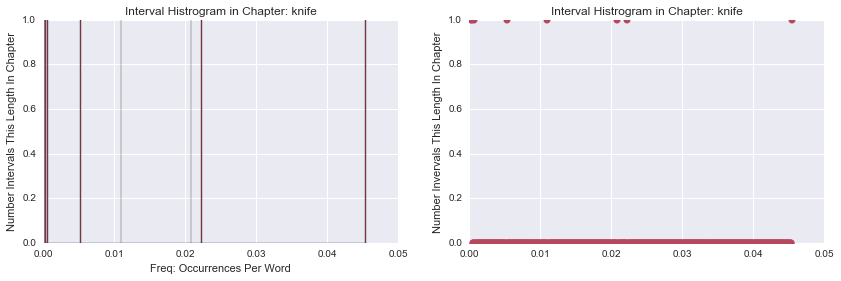

In [257]:
key = 'knife'
Nbins = 500
sample_compression_factor = len(wdf[key])/Nbins
print sample_compression_factor

counts = []
counter = 1
for (ii,yy) in enumerate(wdf[key]):
    if yy>0:
        counts.append(counter)
        counter = 1
    else:
        counter += 1

invcounts = [1/c for c in counts]

fig = figure(figsize=(14,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

h = ax1.hist(invcounts,bins=Nbins,color=colors[2])
ax1.set_xlabel('Freq: Occurrences Per Word')
ax1.set_ylabel('Number Intervals This Length In Chapter')
ax1.set_title("Interval Histrogram in Chapter: %s"%(key))


meanx = [ np.mean([h[1][i],h[1][i+1]]) for i in range(h[1].size-1) ]
ax2.plot(meanx,h[0],'o',color=colors[2])
ax1.set_xlabel('Freq: Occurrences Per Word')
ax2.set_ylabel('Number Invervals This Length In Chapter')
ax2.set_title("Interval Histrogram in Chapter: %s"%(key))

show()

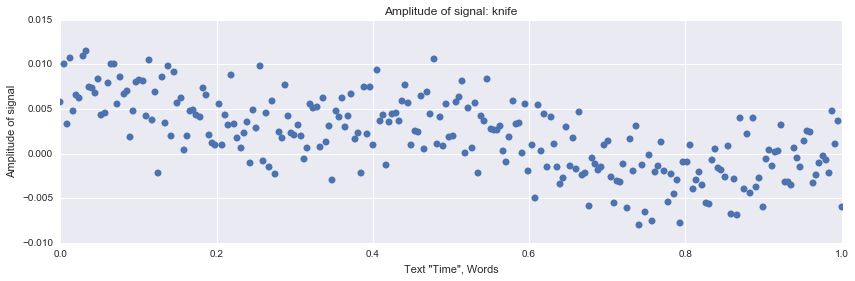

In [258]:
newY = h[0]
newy = np.fft.ifft(newY)

fig = figure(figsize=(14,4))
ax1 = fig.add_subplot(111)

newy_plt = newy[1:int(len(newy)/2)-1]
newx_plt = np.linspace(0,1,len(newy_plt))

ax1.plot(newx_plt, newy_plt, 'o')
ax1.set_xlabel('Text "Time", Words')
ax1.set_ylabel("Amplitude of signal")
ax1.set_title("Amplitude of signal: %s"%(key))

show()

In [259]:
def plot_fft_signal(key,wdf):
    Nbins = 500
    sample_compression_factor = len(wdf[key])/Nbins
    print sample_compression_factor
    
    regex_to_column('said','^said',wdf)

    counts = []
    counter = 1
    for (ii,yy) in enumerate(wdf[key]):
        if yy>0:
            counts.append(counter)
            counter = 1
        else:
            counter += 1

    invcounts = [1/c for c in counts]

    fig = figure(figsize=(14,4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    h = ax1.hist(invcounts,bins=Nbins,color=colors[2])
    ax1.set_xlabel('Freq: Occurrences Per Word')
    ax1.set_ylabel('Number Intervals This Length In Chapter')
    ax1.set_title("Interval Histrogram in Chapter: %s"%(key))


    meanx = [ np.mean([h[1][i],h[1][i+1]]) for i in range(h[1].size-1) ]
    ax2.plot(meanx,h[0],'o',color=colors[2])
    ax1.set_xlabel('Freq: Occurrences Per Word')
    ax2.set_ylabel('Number Invervals This Length In Chapter')
    ax2.set_title("Interval Histrogram in Chapter: %s"%(key))

    show()

    newY = h[0]
    newy = np.fft.ifft(newY)

    fig = figure(figsize=(14,4))
    ax1 = fig.add_subplot(111)

    newy_plt = newy[1:int(len(newy)/2)-1]
    newx_plt = np.linspace(0,1,len(newy_plt))

    ax1.plot(newx_plt, newy_plt, 'o')
    ax1.set_xlabel('Text "Time", Words')
    ax1.set_ylabel("Amplitude of signal")
    ax1.set_title("Amplitude of signal: %s"%(key))

    show()



In [ ]:
plot_fft_signal(

<a name="wavelets"></a>
## Using Wavelets to Examine the Time-Frequency Domain

While the Fourier transform of the word occurrence vector gave some interesting results, they can be hard to interpret because they remove time information. A better approach would tell us about the frequency domain and the frequencies that occur, while also retaining information about when they occur. This would allow us to more easily spot when and how words are clustered throughout the chapter.

It turns out that the wavelet is a mathematical tool that can do precisely that - show us information about both the time and frequency domains.

In [177]:
colorz = ['bluish green','cornflower','dark rose','dark sea green','watermelon','grassy green','carmine','sunflower yellow','orange pink']
colors = [sns.xkcd_rgb[key] for key in colorz]

In [178]:
from scipy import signal

def wavelet_column(key,words_df):
    n = len(words_df) # length of signal
    k = np.arange(n) 
    t = words_df.index.values
    y = words_df[key].values
    Y = np.fft.fft(y)

    z = 8
    
    widths = np.arange(1, 2**z - 1)#31)
    cwtmatr = signal.cwt(y, signal.ricker, widths)

    
    figure(figsize=(14,4))
    imshow(cwtmatr, extent=[0, n, 2**z - 1, 1], cmap='PRGn', aspect='auto',
               vmax=abs(cwtmatr).max()/1.5, vmin=-abs(cwtmatr).max()/1.5)
    title("Wavelet: "+str(key))
    xlabel('Word Location')
    #ylabel('Wavelet Bandwidth')
    
    fig = figure(figsize=(14,4))
    ax=fig.add_subplot(111)
    plot(t,cwtmatr[20,:],color=colors[3],label="width=10")
    plot(t,cwtmatr[253,:],color=colors[4],label="width=253")
    title("1D Slice of Wavelet: "+str(key))
    legend()
    
    return cwtmatr


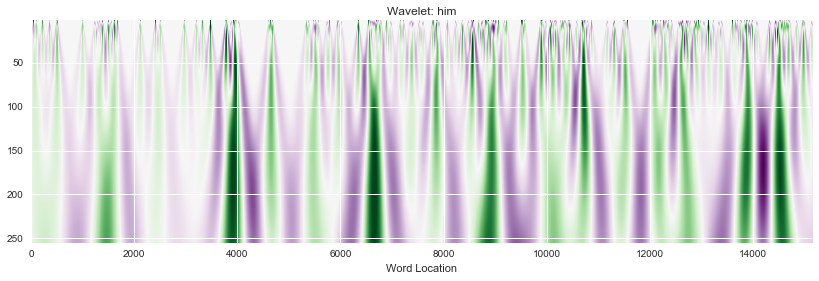

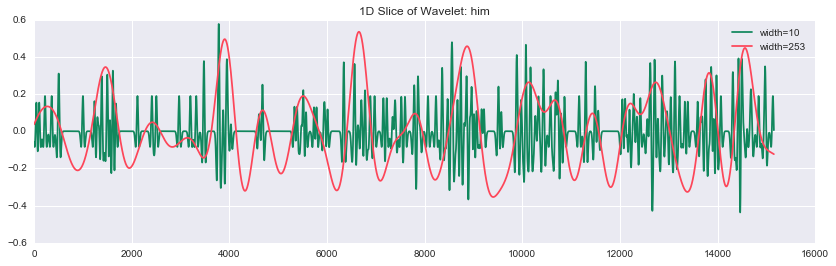

In [179]:
himcwt = wavelet_column('him',wdf)

This wavelet plot can be interpreted in an intuitive way - peaks indicate where the word in question is most likely to occur, and as we move down the plot we "smear out" the local ups and downs and end up with smoother peaks and dips. 

It is not clear, however, what the scale means. As the filter gets wider and wider, the average of the function over the entire series begins to increase, until it is about 10% of the value of the quantities plotted. The sum of the terms also increases, and is about 160 for the widest filter (shown in __red__ above).

However, just because we can't interpret the scale doesn't mean the information isn't useful!

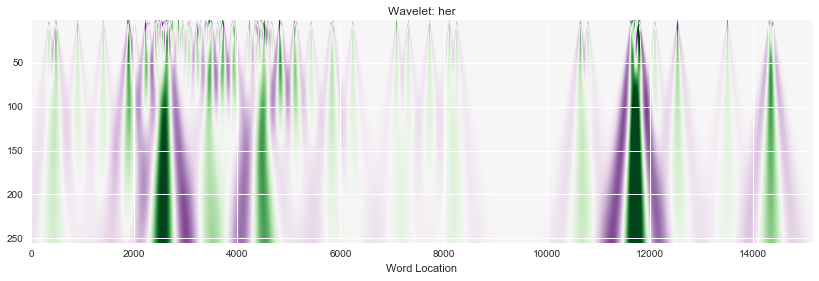

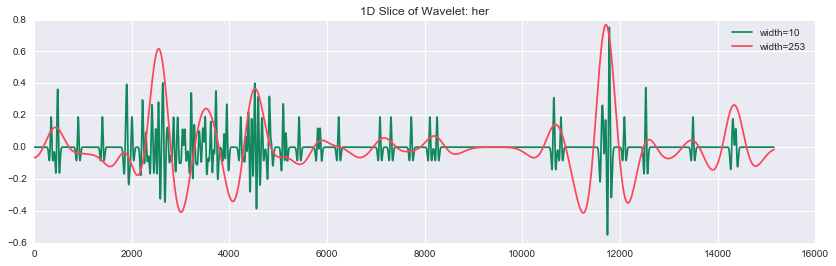

In [250]:
hercwt = wavelet_column('her',wdf)

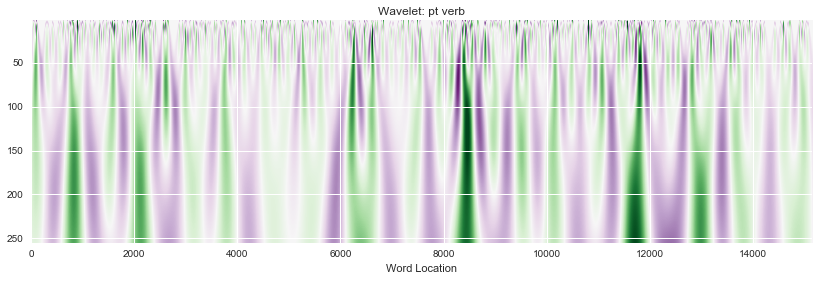

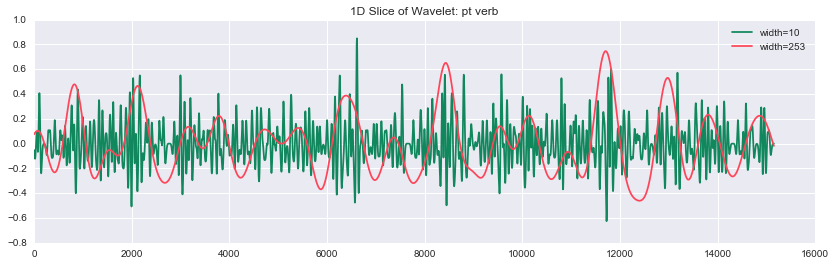

In [251]:
ptverbcwt = wavelet_column('pt verb',wdf)

There is a lot of information contained in these figures, so let's go through them one piece at a time.

Imagine that, along the top of the first figure, we have the vector of occurrences of words matching the regular expression `'^yellow'`, which will match any words beginning with "yellow" (including "yellowish"). This is a matrix of binary values, 1 or 0 - either the regex matches, or it does not. Accordingly, we use a function with a special form, called a "wavelet," to try and match the data. This is a wave with a particular shape, and we use parameters to try and squeeze it or stretch it to match the data. 

Running from top to bottom, we have high to low frequency modes for the wavelet. At a given y value, for a given wavelet frequency, we fit the wavelet to data - the 0 or 1. 

A slice along the top of the plot, at a high frequency, is shown in __green__ on the bottom plot. The function tracks the up and down movement of the function, although it overcompensates by going negative.

As the plot moves downward, the frequency of the wavelet decreases, and the length scale increases, so that neighboring points blend together. This increases the scope of local effects. We can visually see that clustering happen in the vertical streaks of the top plot.

A slice along the bottom of the plot, at a lower frequency, is shown in __red__ on the bottom plot. This smooths out the changes and shows the clusters from a larger scope.

By superimposing plots of the last slice, we get a picture of where a word is more or less likely to occur, and can see collocations of ideas and words in the chapter. For example, we see a peak in past-tense verbs coinciding with the word "her", starting near word 11,500.

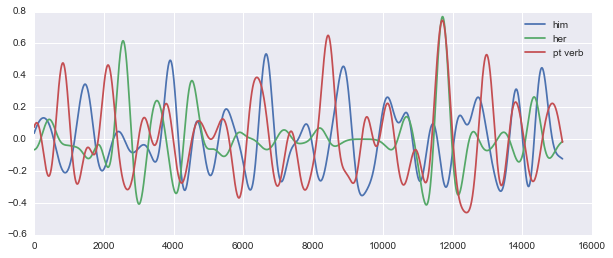

In [252]:
fig = figure(figsize=(10,4))
ax1 = fig.add_subplot(111)


for label,cwt in zip(['him','her','pt verb'],[himcwt,hercwt,ptverbcwt]):
    ax1.plot(range(shape(cwt)[1]), cwt[253,:], label=label)
    
#ax.plot(hercwt[253,:]
#ax.plot(ptverbcwt[253,:]

legend()
show()

<a name="chunking"></a>
## Chunking Chapters with Wavelets

Analyzing the locations of particular words or word patterns gives a function with peaks in areas where that word is likely to occur. Now, suppose we wanted to chunk the novel into sections that, say, had a lot of past tense verbs. Let's look at how we would do that.

We'll use the result of the wavelet function with the widest filter, shown in the image above. We'll extract chunks from the novel wehre past tense verbs are likely to occur. 

In [299]:
def plot_print_hifreq_sections(key,cwt,beta):
    
    df = pd.DataFrame( cwt[253,:], columns=[key] )
    
    sub = df[df[key]>beta]
    
    sub.plot(figsize=(8,4))
    
    xlabel('Word Location')
    ylabel('Wavelet Value')
    title("Hi Frequency Wavelet Sections: %s"%(key))
    show()
    
    
    ##### 
    # This is a neat algorithm
    # to group continouous integers.
    data = sub.index
    
    from operator import itemgetter
    from itertools import groupby
    start = []
    stop = []
    for k, g in groupby(enumerate(data), lambda (i,x):i-x):
        intervals = map(itemgetter(1), g)
        start.append(intervals[0])
        stop.append(intervals[-1])

    # Now we can access/print out each start/stop line number 
    # corresponding to chunks with many past tense verbs
    for (c,(i,j)) in enumerate(zip(start,stop)):
        print "Interval %d: Words %d to %d"%(c+1,i,j)

    for ii,jj in zip(start,stop):
        print "-"*20
        print ' '.join([words[c] for c in range(ii,jj)])


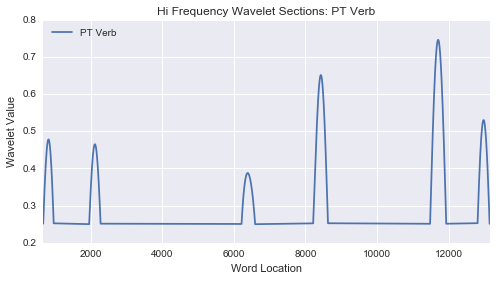

Interval 1: Words 678 to 971
Interval 2: Words 1961 to 2281
Interval 3: Words 6216 to 6596
Interval 4: Words 8216 to 8630
Interval 5: Words 11481 to 11932
Interval 6: Words 12807 to 13143
--------------------
strongly , wheeling between the gaunt quaywalls , gulls . Rough weather outside . If I threw myself down ? Reuben J’s son must have swallowed a good bellyful of that sewage . One and eightpence too much . Hhhhm . It’s the droll way he comes out with the things . Knows how to tell a story too . They wheeled lower . Looking for grub . Wait . He threw down among them a crumpled paper ball . Elijah thirtytwo feet per sec is com . Not a bit . The ball bobbed unheeded on the wake of swells , floated under by the bridgepiers . Not such damn fools . Also the day I threw that stale cake out of the Erin’s King picked it up in the wake fifty yards astern . Live by their wits . They wheeled , flapping . The hungry famished gull Flaps o’er the waters dull . That is how poets write , the simila

In [300]:
plot_print_hifreq_sections('PT Verb',ptverbcwt,beta=0.25)

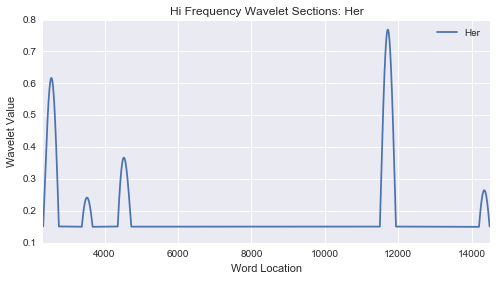

Interval 1: Words 2329 to 2756
Interval 2: Words 3381 to 3674
Interval 3: Words 4358 to 4728
Interval 4: Words 11495 to 11934
Interval 5: Words 14194 to 14483
--------------------
that priestylooking chap was always squinting in when he passed ? Weak eyes , woman . Stopped in Citron’s saint Kevin’s parade . Pen something . Pendennis ? My memory is getting . Pen ... ? Of course it’s years ago . Noise of the trams probably . Well , if he couldn’t remember the dayfather’s name that he sees every day . Bartell d’Arcy was the tenor , just coming out then . Seeing her home after practice . Conceited fellow with his waxedup moustache . Gave her that song Winds that blow from the south . Windy night that was I went to fetch her there was that lodge meeting on about those lottery tickets after Goodwin’s concert in the supperroom or oakroom of the Mansion house . He and I behind . Sheet of her music blew out of my hand against the High school railings . Lucky it didn’t . Thing like that spoils t

In [302]:
plot_print_hifreq_sections('Her',hercwt,beta=0.15)

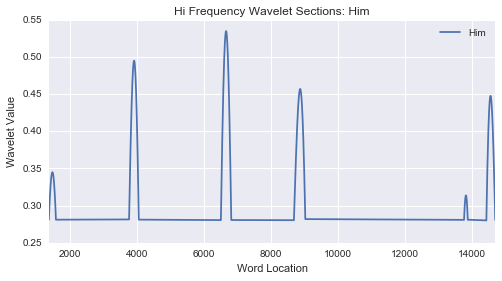

Interval 1: Words 1355 to 1567
Interval 2: Words 3754 to 4044
Interval 3: Words 6499 to 6809
Interval 4: Words 8682 to 9022
Interval 5: Words 13768 to 13879
Interval 6: Words 14435 to 14700
--------------------
Fascinating little book that is of sir Robert Ball’s . Parallax . I never exactly understood . There’s a priest . Could ask him . Par it’s Greek : parallel , parallax . Met him pike hoses she called it till I told her about the transmigration . O rocks ! Mr Bloom smiled O rocks at two windows of the ballastoffice . She’s right after all . Only big words for ordinary things on account of the sound . She’s not exactly witty . Can be rude too . Blurt out what I was thinking . Still , I don’t know . She used to say Ben Dollard had a base barreltone voice . He has legs like barrels and you’d think he was singing into a barrel . Now , isn’t that wit . They used to call him big Ben . Not half as witty as calling him base barreltone . Appetite like an albatross . Get outside of a baron 

In [322]:
plot_print_hifreq_sections('Him',himcwt,beta=0.28)

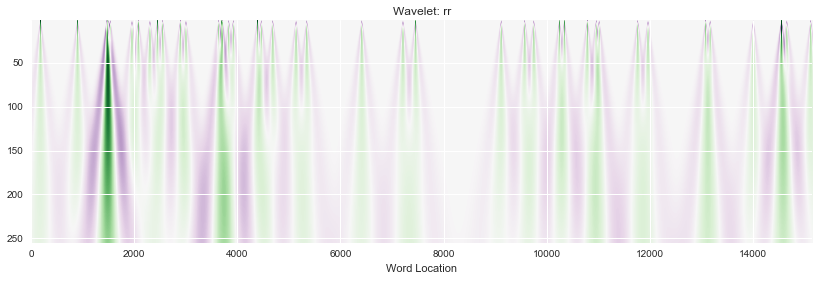

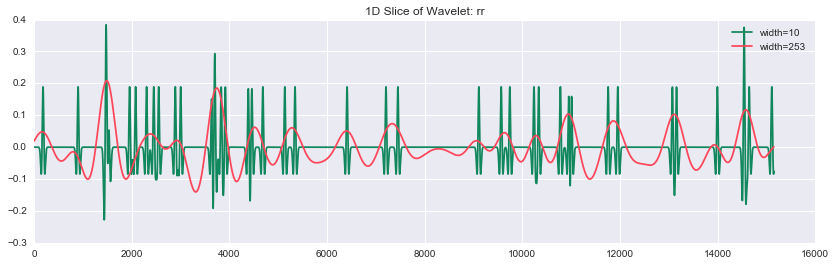

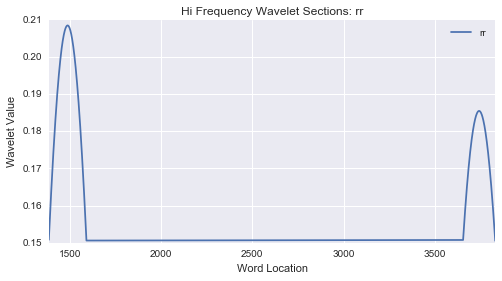

Interval 1: Words 1385 to 1591
Interval 2: Words 3654 to 3830
--------------------
, parallax . Met him pike hoses she called it till I told her about the transmigration . O rocks ! Mr Bloom smiled O rocks at two windows of the ballastoffice . She’s right after all . Only big words for ordinary things on account of the sound . She’s not exactly witty . Can be rude too . Blurt out what I was thinking . Still , I don’t know . She used to say Ben Dollard had a base barreltone voice . He has legs like barrels and you’d think he was singing into a barrel . Now , isn’t that wit . They used to call him big Ben . Not half as witty as calling him base barreltone . Appetite like an albatross . Get outside of a baron of beef . Powerful man he was at stowing away number one Bass . Barrel of Bass . See ? It all works out . A procession of whitesmocked sandwichmen marched slowly towards him along the gutter , scarlet sashes across their boards . Bargains . Like that priest they are this morning : we

In [323]:
regex_to_column('rr', r'rr', wdf)
rrcwt = wavelet_column('rr',wdf)
plot_print_hifreq_sections('rr',rrcwt,beta=0.15)

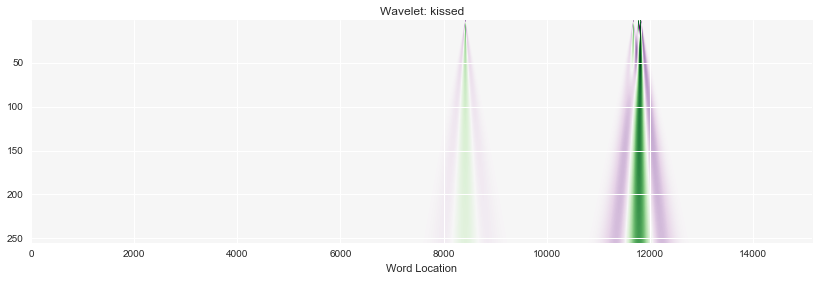

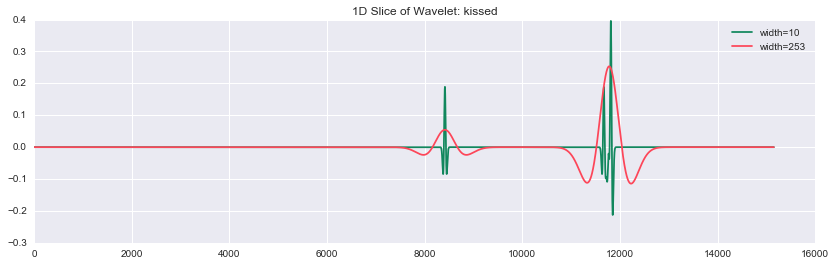

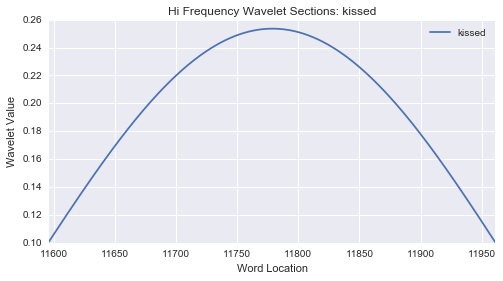

Interval 1: Words 11596 to 11961
--------------------
. Fields of undersea , the lines faint brown in grass , buried cities . Pillowed on my coat she had her hair , earwigs in the heather scrub my hand under her nape , you’ll toss me all . O wonder ! Coolsoft with ointments her hand touched me , caressed : her eyes upon me did not turn away . Ravished over her I lay , full lips full open , kissed her mouth . Yum . Softly she gave me in my mouth the seedcake warm and chewed . Mawkish pulp her mouth had mumbled sweetsour of her spittle . Joy : I ate it : joy . Young life , her lips that gave me pouting . Soft warm sticky gumjelly lips . Flowers her eyes were , take me , willing eyes . Pebbles fell . She lay still . A goat . No-one . High on Ben Howth rhododendrons a nannygoat walking surefooted , dropping currants . Screened under ferns she laughed warmfolded . Wildly I lay on her , kissed her : eyes , her lips , her stretched neck beating , woman’s breasts full in her blouse of nun’s ve

In [324]:
regex_to_column('kissed', r'kissed', wdf)
kissedcwt = wavelet_column('kissed',wdf)
plot_print_hifreq_sections('kissed',kissedcwt,beta=0.10)

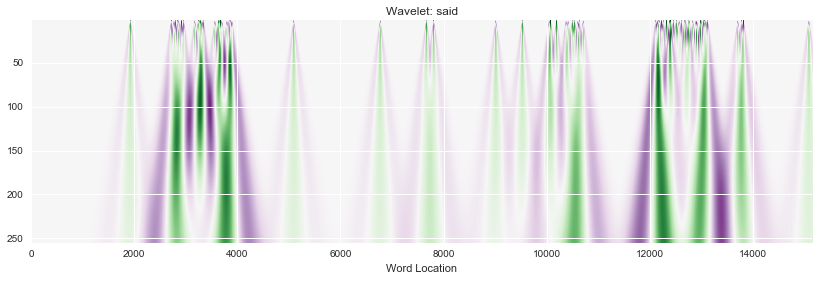

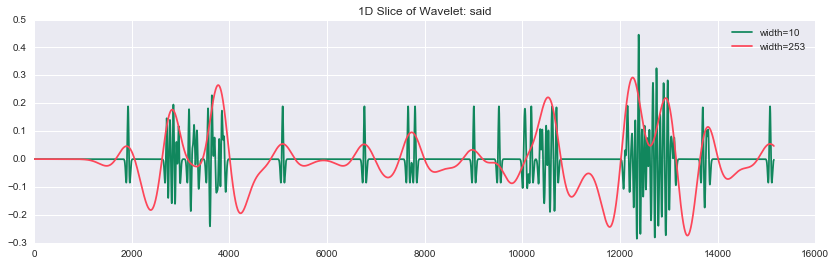

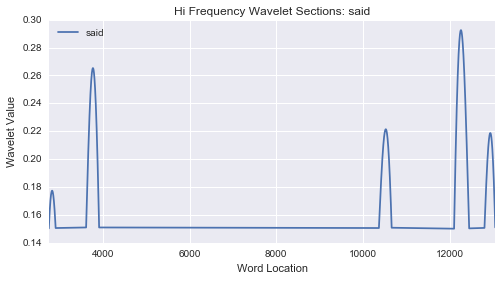

Interval 1: Words 2754 to 2911
Interval 2: Words 3614 to 3914
Interval 3: Words 10368 to 10662
Interval 4: Words 12102 to 12450
Interval 5: Words 12803 to 13051
--------------------
fire . How are all your charges ? —All on the baker’s list , Mrs Breen said . How many has she ? No other in sight . —You’re in black , I see . You have no ... —No , Mr Bloom said . I have just come from a funeral . Going to crop up all day , I foresee . Who’s dead , when and what did he die of ? Turn up like a bad penny . —O , dear me , Mrs Breen said . I hope it wasn’t any near relation . May as well get her sympathy . —Dignam , Mr Bloom said . An old friend of mine . He died quite suddenly , poor fellow . Heart trouble , I believe . Funeral was this morning . Your funeral’s tomorrow While you’re coming through the rye . Diddlediddle dumdum Diddlediddle ... —Sad to lose the old friends ,
--------------------
in Holles street . Dr Horne got her in . She’s three days bad now . —O , Mr Bloom said . I’m sorry

In [325]:
regex_to_column('said', r'said', wdf)
saidcwt = wavelet_column('said',wdf)
plot_print_hifreq_sections('said',saidcwt,beta=0.15)

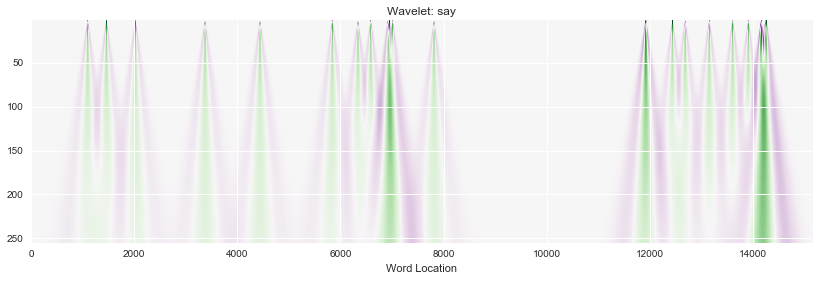

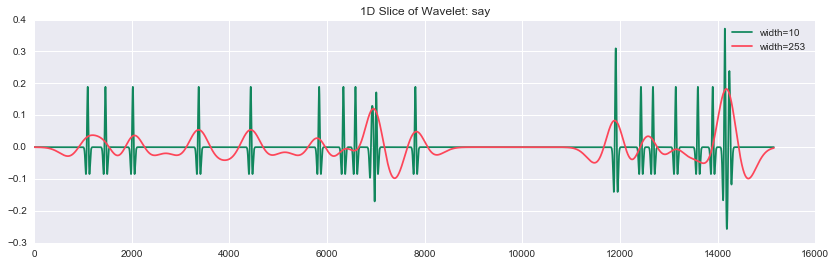

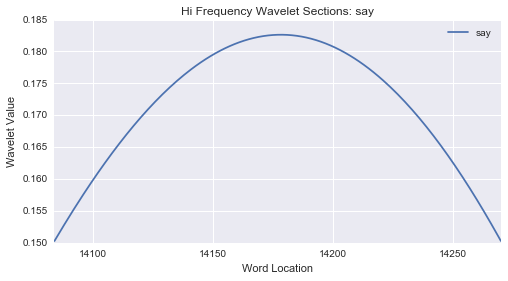

Interval 1: Words 14084 to 14270
--------------------
? Bloodless pious face like a fellow going in to be a priest . Penrose ! That was that chap’s name . Look at all the things they can learn to do . Read with their fingers . Tune pianos . Or we are surprised they have any brains . Why we think a deformed person or a hunchback clever if he says something we might say . Of course the other senses are more . Embroider . Plait baskets . People ought to help . Workbasket I could buy for Molly’s birthday . Hates sewing . Might take an objection . Dark men they call them . Sense of smell must be stronger too . Smells on all sides , bunched together . Each street different smell . Each person too . Then the spring , the summer : smells . Tastes ? They say you can’t taste wines with your eyes shut or a cold in the head . Also smoke in the dark they say get no pleasure . And with a woman , for instance . More shameless not seeing . That


In [326]:
regex_to_column('say', r'say', wdf)
saycwt = wavelet_column('say',wdf)
plot_print_hifreq_sections('say',saycwt,beta=0.15)

There's an interesting pattern here - "said" and "say" switch back and forth in two spots in the chapter.

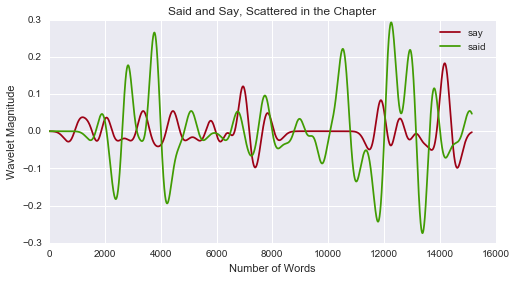

In [333]:
fig = figure(figsize=(8,4))

ax1 = fig.add_subplot(111)
ax1.plot(range(len(saycwt[253,:])),saycwt[253,:], color=colors[6], label='say')
ax1.plot(range(len(saidcwt[253,:])),saidcwt[253,:], color=colors[5], label='said')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Wavelet Magnitude')
ax1.set_title("Said and Say, Scattered in the Chapter")
ax1.legend()

show()

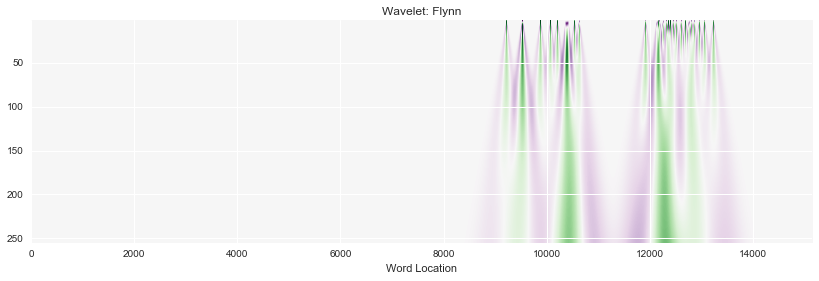

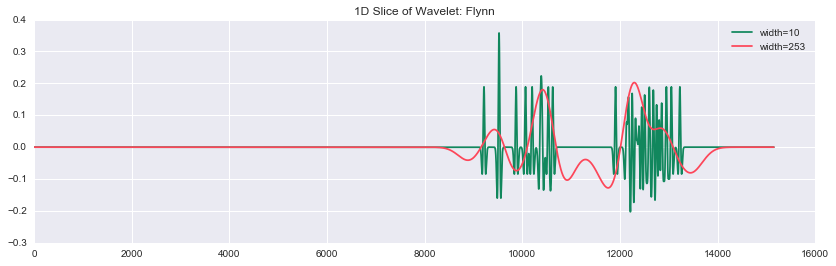

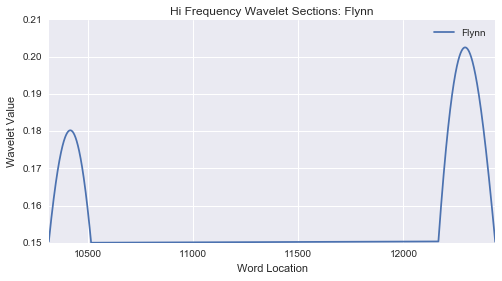

Interval 1: Words 10315 to 10516
Interval 2: Words 12166 to 12436
--------------------
Byrne came forward from the hindbar in tuckstitched shirtsleeves , cleaning his lips with two wipes of his napkin . Herring’s blush . Whose smile upon each feature plays with such and such replete . Too much fat on the parsnips . —And here’s himself and pepper on him , Nosey Flynn said . Can you give us a good one for the Gold cup ? —I’m off that , Mr Flynn , Davy Byrne answered . I never put anything on a horse . —You’re right there , Nosey Flynn said . Mr Bloom ate his strips of sandwich , fresh clean bread , with relish of disgust pungent mustard , the feety savour of green cheese . Sips of his wine soothed his palate . Not logwood that . Tastes fuller this weather with the chill off . Nice quiet bar . Nice piece of wood in that counter . Nicely planed . Like the way it curves there . —I wouldn’t do anything at all in that line , Davy Byrne said . It ruined many a man , the same horses . Vintners’

In [334]:
regex_to_column('Flynn', r'Flynn', wdf)
rrcwt = wavelet_column('Flynn',wdf)
plot_print_hifreq_sections('Flynn',rrcwt,beta=0.15)